<a href="https://colab.research.google.com/github/bobbercheng/ventilator-pressure-prediction/blob/master/ventilator_pressure_transformer_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

V1: Add PositionalEncoding

V2: Adjust Transformer parameters

V3: Use Transformer class instead of Tensorflow version

V4: Without EDA and only use 400 features that is very similar to Keras time serial transformer sample if features and time serial are flatten. TPU v2 supports 16 heads, 512 key_dim, 512 batch size. But converge is not good

V5: Max TPU V2 config, 128 heads, 512 key_dim, 512 batch size

In [1]:
# Update pandas version for Colab TPU
#!pip install pandas==1.3.2

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
if IN_COLAB:
  from google.colab import drive
  drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [4]:
if IN_COLAB:
  !pip install kaggle
  !mkdir /root/.kaggle
  !cp /gdrive/MyDrive/ventilator-pressure-prediction/kaggle.json /root/.kaggle
  !kaggle competitions download -c ventilator-pressure-prediction
  !mkdir -p /kaggle/input/ventilator-pressure-prediction
  !unzip '*.zip' -d /kaggle/input/ventilator-pressure-prediction
  !ls /kaggle/input/ventilator-pressure-prediction

 95% 72.0M/75.4M [00:00<00:00, 230MB/s]
100% 75.4M/75.4M [00:00<00:00, 217MB/s]
  0% 0.00/8.50M [00:00<?, ?B/s]
100% 8.50M/8.50M [00:00<00:00, 78.2MB/s]
 91% 126M/139M [00:00<00:00, 93.6MB/s]
100% 139M/139M [00:01<00:00, 131MB/s] 
Archive:  sample_submission.csv.zip
  inflating: /kaggle/input/ventilator-pressure-prediction/sample_submission.csv  

Archive:  train.csv.zip
  inflating: /kaggle/input/ventilator-pressure-prediction/train.csv  

Archive:  test.csv.zip
  inflating: /kaggle/input/ventilator-pressure-prediction/test.csv  

3 archives were successfully processed.
sample_submission.csv  test.csv  train.csv


In [5]:
import numpy as np
import pandas as pd

# import optuna

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

model_folder = '/gdrive/MyDrive/ventilator-pressure-prediction/transformer/'

EPOCH = 300
BATCH_SIZE = 512
NUM_FOLDS = 10

TRANSFORMER_NUM_TRANSFORMER_BLOCKS=8
TRANSFORMER_HEAD_SIZES=[
                        # 768, 512, 
                      768, 512, 256, 128]

TRANSFORMER_NUM_HEADS=[32]*4

TRANSFORMER_OUTPUT_DIMS=[768, 512, 256, 128]

TRANSFORMER_FF_DIMS=[768, 512, 256, 128]

TRANSFORMER_MLP_UNITS=[128, 1]
TRANSFORMER_DROPOUT=0.0
TRANSFORMER_MLP_DROPOUT=0.0

In [6]:
import os
import random
# Deep Learning
import tensorflow as tf
from tensorflow import keras
# Metrics
from sklearn.metrics import mean_absolute_error

# Random Seed Initialize
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything()

In [7]:
DEBUG = False

train = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')
submission = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/sample_submission.csv')

if DEBUG:
    train = train[:80*1000]

In [8]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-5...Completed")
    
    return df

print("Train data...\n")
train = add_features(train)

print("\nTest data...\n")
test = add_features(test)



Train data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed

Test data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed


In [9]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)

train.drop(['pressure','id', 'breath_id'], axis=1, inplace=True)

test = test.drop(['id', 'breath_id'], axis=1)

train.head(), train.shape

(   time_step       u_in  u_out  ...  R__C_5__10  R__C_5__20  R__C_5__50
 0   0.000000   0.083334      0  ...           0           0           0
 1   0.033652  18.383041      0  ...           0           0           0
 2   0.067514  22.509278      0  ...           0           0           0
 3   0.101542  22.808822      0  ...           0           0           0
 4   0.135756  25.355850      0  ...           0           0           0
 
 [5 rows x 59 columns], (6036000, 59))

In [10]:
train.drop(['one','count',
            'breath_id_lag','breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same'], axis=1, inplace=True)

test = test.drop(['one','count','breath_id_lag',
                  'breath_id_lag2','breath_id_lagsame',
                  'breath_id_lag2same'], axis=1)

In [11]:
RS = RobustScaler()
train = RS.fit_transform(train)
test = RS.transform(test)

In [12]:
train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

In [13]:
from tensorflow.keras import layers
from tensorflow import keras

In [14]:
# refer to https://www.tensorflow.org/text/tutorials/transformer#encoder
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def get_positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model


    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

  def get_config(self):
    config = super(MultiHeadAttention, self).get_config()
    config.update({"num_heads": self.num_heads,
            "d_model": self.d_model})
    return config

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

def home_transformer_encoder(inputs, head_size, num_heads, ff_dims, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    x, _ = MultiHeadAttention(d_model=inputs.shape[-1], num_heads=num_heads)(x, k=x, q=x, mask=None)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    # Feed forward can be Den lay or RNN as long as it keep final dimension
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dims, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res

In [41]:
#refer to https://keras.io/examples/timeseries/timeseries_classification_transformer/
def transformer_encoder(inputs, value, head_size, num_heads, ff_dims, dropout=0, output_dim=None):
    # print('transformer_encoder:', inputs.shape, head_size, num_heads, ff_dims, output_dim)
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    #print(head_size, num_heads, output_dim, ff_dims, dropout)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
        # , output_shape=output_dim
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    # Feed forward can be Den lay or CNN as long as it keep final dimension
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dims, kernel_size=1, activation="selu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res

In [42]:
# refer to https://www.tensorflow.org/text/tutorials/transformer#encoder
# https://rubikscode.net/2019/08/19/transformer-with-python-and-tensorflow-2-0-encoder-decoder/
# https://trungtran.io/2019/04/29/create-the-transformer-with-tensorflow-2-0/
# https://github.com/ChunML/NLP/blob/master/chatbot/model.py
def build_transfer_model(
    input_shape,
    head_sizes=TRANSFORMER_HEAD_SIZES,
    num_heads=TRANSFORMER_NUM_HEADS,
    output_dims=TRANSFORMER_OUTPUT_DIMS,
    ff_dims=TRANSFORMER_FF_DIMS,
    num_transformer_blocks=TRANSFORMER_NUM_TRANSFORMER_BLOCKS,
    mlp_units=TRANSFORMER_MLP_UNITS,
    dropout=TRANSFORMER_DROPOUT,
    mlp_dropout=TRANSFORMER_MLP_DROPOUT,
):

    inputs = keras.Input(shape=input_shape)
    time_lenght = input_shape[0]
    positional_encoding = get_positional_encoding(time_lenght, input_shape[-1])
    # print('positional_encoding:', positional_encoding)

    x = inputs

    # increase x then add position encoding.
    '''
    The reason we increase the embedding values before the addition is to make 
    the positional encoding relatively smaller. This means the original meaning 
    in the embedding vector won’t be lost when we add them together.
    '''
    x *= tf.math.sqrt(tf.cast(input_shape[-1], tf.float32))
    x += positional_encoding[:, :time_lenght, :]

    #add x dimension to [batch, 80, 53+11=64] for home transformer encoder
    #x = tf.concat([x, tf.zeros_like(x[:,:,0:11])], -1)

    #Reshape x to (batch size, sequence length * features, 1)
    #x = tf.reshape(x, [-1, x.shape[1]*x.shape[-1], 1])

    # for head_size, num_head, ff_dim, output_dim in zip(head_sizes, num_heads, ff_dims, output_dims):
    #     x = transformer_encoder(x, head_size, num_head, ff_dim, dropout, output_dim)
    i = 0
    # print(head_sizes, num_heads, ff_dims, dropout, output_dims)
    x1 = transformer_encoder(x, x, head_sizes[i], num_heads[i], ff_dims[i], dropout, output_dims[i])
    i = 1
    x2 = transformer_encoder(x1, x, head_sizes[i], num_heads[i], ff_dims[i], dropout, output_dims[i])
    i = 2
    x3 = transformer_encoder(x2, x, head_sizes[i], num_heads[i], ff_dims[i], dropout, output_dims[i])
    i = 3
    x4 = transformer_encoder(x3, x, head_sizes[i], num_heads[i], ff_dims[i], dropout, output_dims[i])

    nDim = 256
    z2 = transformer_encoder(x2, x, nDim, num_heads[i], nDim, dropout, nDim)
    nDim = 128
    z3 = transformer_encoder(layers.Add()([x3, z2]), x, nDim, num_heads[i], nDim, dropout, nDim)
    nDim = 64
    z4 = transformer_encoder(layers.Add()([x4, z3]), x, nDim, num_heads[i], nDim, dropout, nDim)

    x = layers.Concatenate(axis=2)([x4, z2, z3, z4])

    for dim in mlp_units[:-1]:
        x = layers.Dense(dim, activation="selu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    outputs = layers.Dense(mlp_units[-1])(x)

    model = keras.Model(inputs, outputs)
    model.summary()
    return model

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 80, 53)]     0                                            
__________________________________________________________________________________________________
tf.math.multiply_11 (TFOpLambda (None, 80, 53)       0           input_12[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.add_91 (TFOpLa (None, 80, 53)       0           tf.math.multiply_11[0][0]        
__________________________________________________________________________________________________
layer_normalization_129 (LayerN (None, 80, 53)       106         tf.__operators__.add_91[0][0]    
____________________________________________________________________________________________

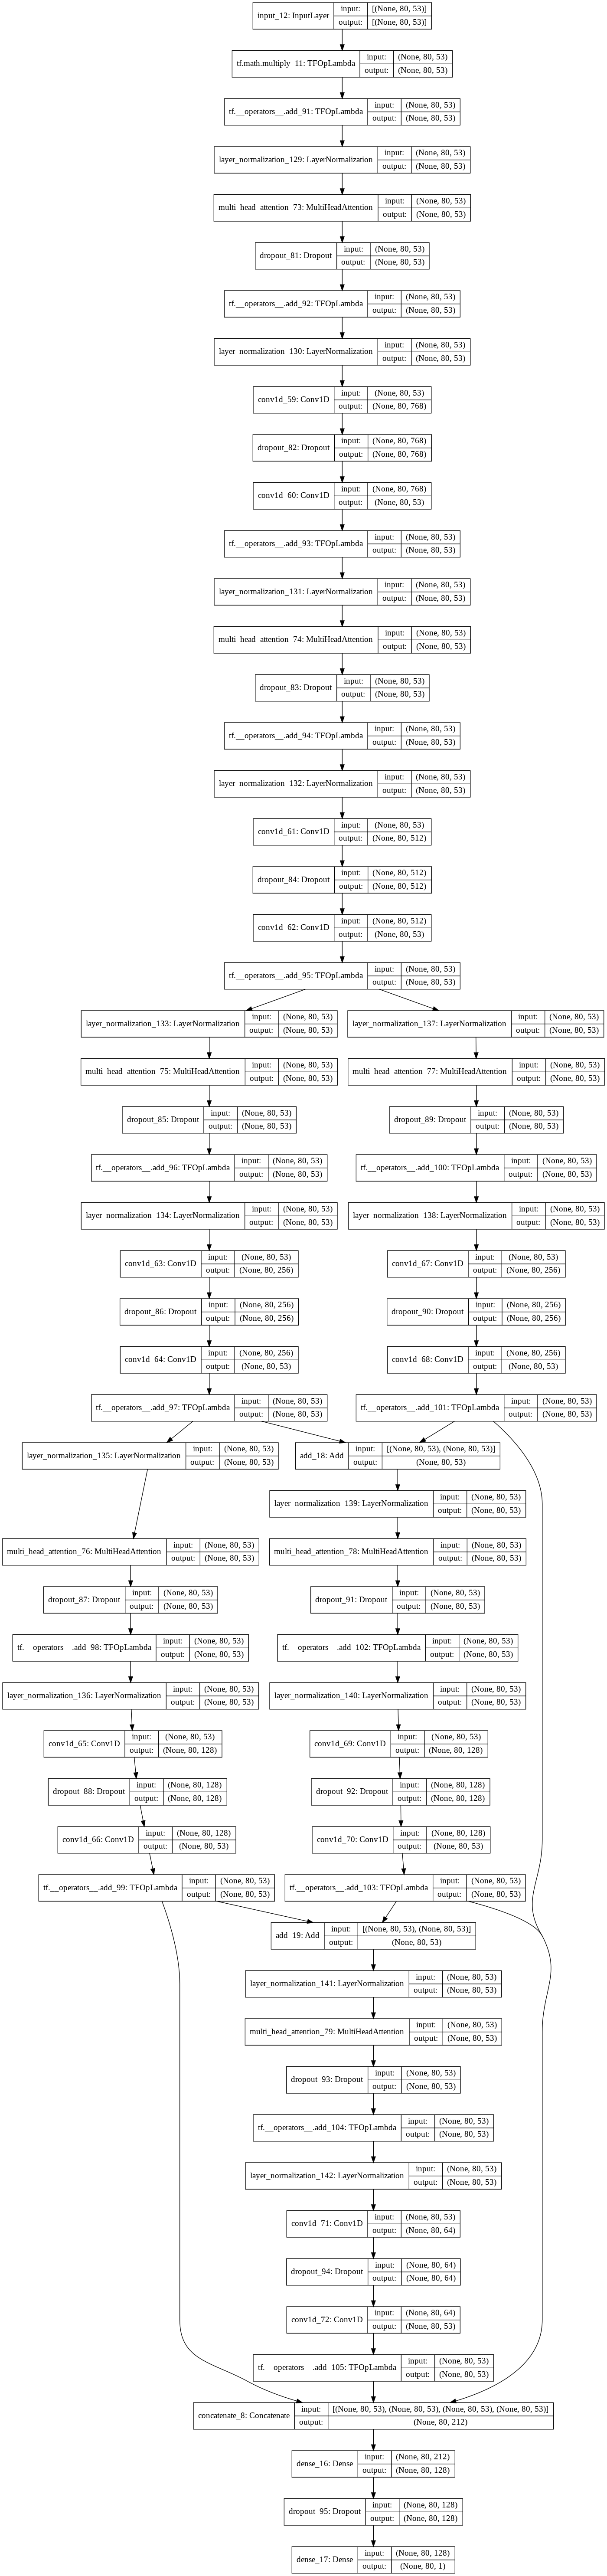

In [43]:
from tensorflow.keras.utils import plot_model
model = build_transfer_model(train.shape[1:])
plot_model(
    model, 
    to_file='Google_Brain_Keras_Model.png', 
    show_shapes=True,
    show_layer_names=True
)

In [18]:
# Function to get hardware strategy
def get_hardware_strategy():
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tf.config.optimizer.set_jit(True)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

    return tpu, strategy

tpu, strategy = get_hardware_strategy()

Running on TPU  grpc://10.69.244.10:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.69.244.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.244.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

with strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    train_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        #u_out_train, u_out_valid = u_outs[train_idx], u_outs[test_idx]
        
        #model = get_cnn_model(train)
        model = build_transfer_model(train.shape[1:])
        model.compile(optimizer='adam', 
                      # loss=GBVPP_loss,
                      loss="mae"
                      )

        #scheduler = ExponentialDecay(1e-3, 40*((len(train)*0.8)/BATCH_SIZE), 1e-5)
        #lr = LearningRateScheduler(scheduler, verbose=1)
        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.75, patience=10, verbose=1)
        es = EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min", restore_best_weights=True)
        checkpoint_filepath = f"folds{fold}.hdf5"
        sv = keras.callbacks.ModelCheckpoint(
            checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
            save_weights_only=False, mode='auto', save_freq='epoch',
            options=None)

        history = model.fit(X_train,
                            y_train,
                            # validation_data=(X_valid, np.append(y_valid, u_out_valid, axis =1)), 
                            validation_data=(X_valid, y_valid), 
                            epochs=EPOCH, 
                            batch_size=512, #GPU only can use 64 as batch size
                            callbacks=[lr,
                                       es,
                                       sv])
        
        if IN_COLAB:
          with open(model_folder+checkpoint_filepath, 'wb') as f:
            f.write(open(checkpoint_filepath, 'rb').read())
    
        test_preds.append(model.predict(test).squeeze().reshape(-1, 1).squeeze())
        train_preds.append(model.predict(train).squeeze().reshape(-1, 1).squeeze())


--------------- > Fold 1 < ---------------
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 80, 53)]     0                                            
__________________________________________________________________________________________________
tf.math.multiply_12 (TFOpLambda (None, 80, 53)       0           input_13[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.add_106 (TFOpL (None, 80, 53)       0           tf.math.multiply_12[0][0]        
__________________________________________________________________________________________________
layer_normalization_143 (LayerN (None, 80, 53)       106         tf.__operators__.add_106[0][0]   
_________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
133/133 [==============================] - 19s 143ms/step - loss: 1.8124 - val_loss: 1.5475

Epoch 00002: val_loss improved from 1.97577 to 1.54750, saving model to folds0.hdf5
Epoch 3/300
133/133 [==============================] - 19s 143ms/step - loss: 1.7534 - val_loss: 1.7332

Epoch 00003: val_loss did not improve from 1.54750
Epoch 4/300
133/133 [==============================] - 19s 143ms/step - loss: 1.5479 - val_loss: 1.3492

Epoch 00004: val_loss improved from 1.54750 to 1.34918, saving model to folds0.hdf5
Epoch 5/300
133/133 [==============================] - 19s 143ms/step - loss: 1.2628 - val_loss: 1.3282

Epoch 00005: val_loss improved from 1.34918 to 1.32822, saving model to folds0.hdf5
Epoch 6/300
133/133 [==============================] - 19s 143ms/step - loss: 1.3644 - val_loss: 1.8320

Epoch 00006: val_loss did not improve from 1.32822
Epoch 7/300
133/133 [==============================] - 19s 143ms/step - loss: 1.1699 - val_loss: 1.1462

Epoch 00007: val

In [ ]:
mae(targets.flatten(), np.median(np.vstack(train_preds),axis=0))

In [ ]:
PRESSURE_STEP = 0.07030214545120961
PRESSURE_MIN = -1.8957442945646408
PRESSURE_MAX = 64.82099173863948

In [ ]:
# ENSEMBLE FOLDS WITH MEAN
submission["pressure"] = sum(test_preds)/len(test_preds)
submission.to_csv('submission_mean.csv', index=False)

In [ ]:
# ENSEMBLE FOLDS WITH MEDIAN
submission["pressure"] = np.median(np.vstack(test_preds),axis=0)
submission.to_csv('submission_median.csv', index=False)

In [ ]:
# ENSEMBLE FOLDS WITH MEDIAN AND ROUND PREDICTIONS
submission["pressure"] =\
    np.round( (submission.pressure - PRESSURE_MIN)/PRESSURE_STEP ) * PRESSURE_STEP + PRESSURE_MIN
submission.pressure = np.clip(submission.pressure, PRESSURE_MIN, PRESSURE_MAX)
submission.to_csv('submission_median_round.csv', index=False)

In [ ]:
if IN_COLAB:
  !zip cnn_models.zip *.hdf5
  !zip submission.zip *.csv
  with open(model_folder + 'submission.zip', 'wb') as f:
    f.write(open('submission.zip', 'rb').read())
  with open(model_folder + 'cnn_models.zip', 'wb') as f:
    f.write(open('cnn_models.zip', 'rb').read())